DSCI100/002 Group 5

Decoding Legendary Pokemon 

Introduction:

   Pokemon is an entertainment franchise created by Nintendo that surrounds a make-believe world where people catch, train and battle creatures known as Pokemon (Pokemon, 2015). The Nintendo company continues to expand the world of Pokemon, creating new regions and Pokemon for eager fans to discover, train and battle.
    The Pokemon are created with various statistics, appearances and personalities. In the games, which our data set and analysis are focused on, we as the player create teams of Pokemon and travel across various regions to battle other trainers and wild Pokemon (Padilla, 2003). All Pokemon have set statistics determining how powerful they are, with the highly desirable and exclusive  “Legendary Pokemon” that tend to have much higher statistics than most of the non-legendaries. 
    
   Our predictive question is to determine whether a hypothetical Pokemon we create with random statistics is considered legendary. We will analyse different statistics of all the Pokemon up to the sixth generation, the Pokemon X and Y games, to determine what constitutes a legendary. Using our findings we will be able to create a model where we can create a new Pokemon and determine whether it would be considered a legendary or not.


In [1]:
#install.packages("themis")

The 'themis' package was used to further organize unbalanced data as our dataset mainly contained 'non-lengendary pokemon', the clustering would have a lower accuracy. This is due to most of the pokemon being automatically classified as non-legendary even if it's supposed to be legendary.

Please remove the hashtag when running this line, then add the hashtag back before restarting and running the kernel. 

In [26]:
#loading required libraries for the analysis. Install the packages if they are not previously installed.
library(rvest)
library(tidymodels)
library(themis)
library(tidyverse)
library(cowplot)
set.seed(100)

In [3]:
#Reading web data using GitHub generated URL link

url <- "https://raw.githubusercontent.com/dlee03/DSCI_group_project/main/Pokemon.csv" 

pokemon2 <- read_csv(url)
colnames(pokemon2) <- make.names(colnames(pokemon2)) 
head(pokemon2)

Rows: 800 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Name, Type 1, Type 2
dbl (9): #, Total, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, Generation
lgl (1): Legendary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,FALSE
4,Charmander,Fire,NA,309,39,52,43,60,50,65,1,FALSE
5,Charmeleon,Fire,NA,405,58,64,58,80,65,80,1,FALSE


Table 1. Pokemon Dataset

This data set is called 'Pokemon with Stats' from Kaggle, by using GitHub, we are able to generate a unique URl which can be read directly into R. This data was created by the user Alberto Barradas, containing the names of pokemon and all of their associated statistics, and a classification of either legendary or not legendary as variables (Pokemon, 2015). As this dataset contains all the Pokemon up to the sixth generation and their associated statistics, we will be able to create our desired model. 


In [4]:
#summarize data that reports number of entries per column 

pokemon_selected <- pokemon2 |>
    select(Name, HP, Attack, Defense, Sp..Atk, Sp..Def, Speed, Legendary)
head(pokemon_selected)

Name,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Legendary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Bulbasaur,45,49,49,65,65,45,FALSE
Ivysaur,60,62,63,80,80,60,FALSE
Venusaur,80,82,83,100,100,80,FALSE
VenusaurMega Venusaur,80,100,123,122,120,80,FALSE
Charmander,39,52,43,60,50,65,FALSE
Charmeleon,58,64,58,80,65,80,FALSE


Table 2. Selected Name, Attack, Defense, Attack Speed, Defense Speed, Speed, and Legendary columns.

We will analyse different statistics of all the Pokemon up to the sixth generation, the Pokemon X and Y games, to determine what constitutes a legendary. Using our findings we will be able to create a model where we can create a new Pokemon and determine whether it would be considered a legendary or not. The statistics we will be analysing are as follows: Attack (atk) and Special (sp.atk), the amount of damage a Pokemon does with physical and special attack respectively. Defence (def) and special defence (sp. def) which are the amount of damage that the Pokemon can negate from physical and special attacks. Speed (spd), which determines which Pokemon attacks first during battle. Lastly, we are also looking at health points (hp), the amount of damage a Pokemon can take before fainting in battle (Serebii.net, 2023).

In [5]:
#find counts in each
pokemon_counts <- pokemon_selected |> 
    group_by() |>
    summarize(counts = n())
head(pokemon_counts)

sum(is.na(pokemon_counts)) #check if there is any missing data in the dataframe

counts
<int>
800


[1] 0

By using summarize counts, we use pokemon_counts to represent the number of rows/observations present in the data frame. We also checked for missing data as the final indicator to whether or not we need to continue cleaning the data before training the model. 

In [6]:
#convert the character variable to the factor datatype
pokemon_data <- pokemon_selected |>
    mutate(Legendary = as_factor(Legendary)) 

The final step we used to clean and wrangle the data was to convert the Legendary column into a factor, which allows statistical functions to be made on these values. 

In [7]:
#visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis 

p_stat_avg <- pokemon_data |> 
    select(HP:Legendary) |> 
    group_by(Legendary) |>
    summarize(across(HP:Speed, mean)) |>
    pivot_longer(cols = HP:Speed, 
                 names_to = "pokemon_category", 
                 values_to = "mean_value")
p_stat_avg

Legendary,pokemon_category,mean_value
<fct>,<chr>,<dbl>
FALSE,HP,67.18231
FALSE,Attack,75.66939
FALSE,Defense,71.55918
FALSE,Sp..Atk,68.45442
FALSE,Sp..Def,68.89252
FALSE,Speed,65.45578
TRUE,HP,92.73846
TRUE,Attack,116.67692
TRUE,Defense,99.66154


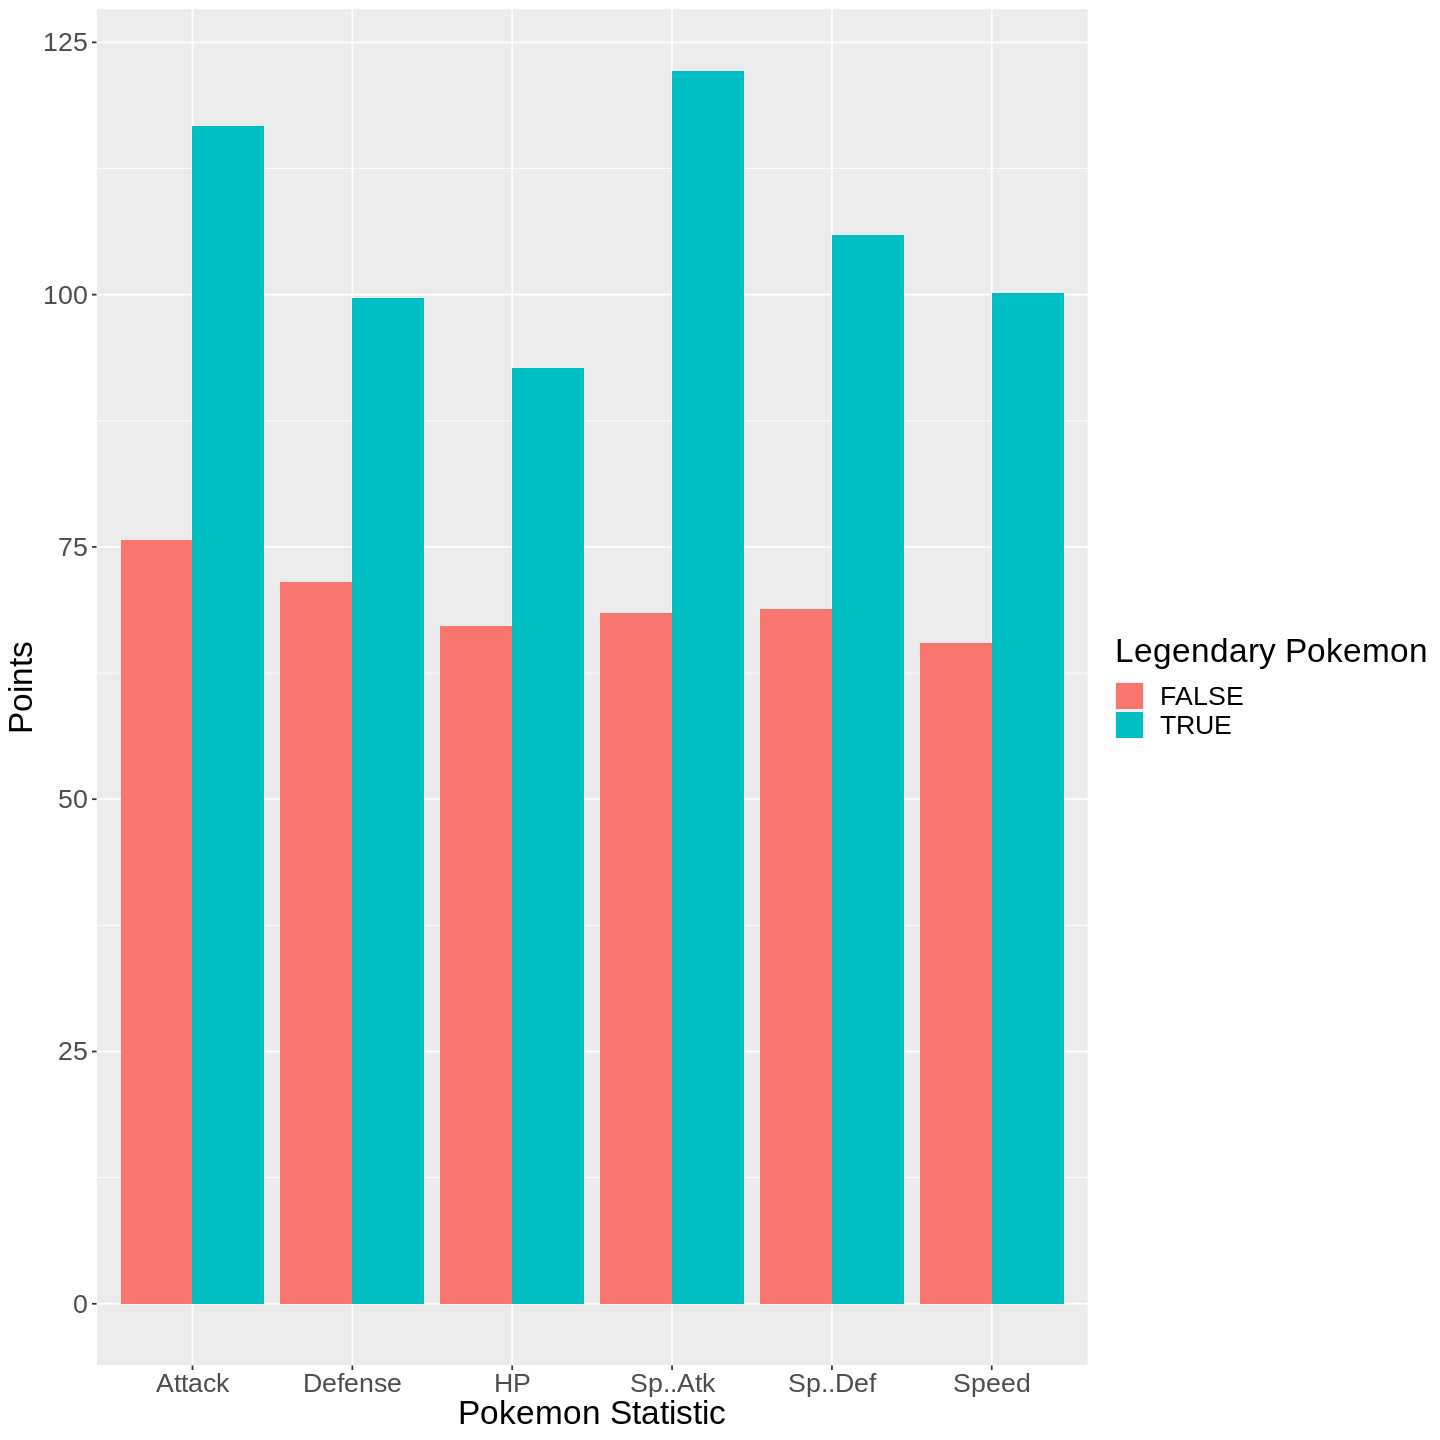

In [24]:
options(repr.plot.width = 12, repr.plot.height =12)
pokemon_bar <- ggplot(p_stat_avg, aes(x = pokemon_category, y = mean_value, fill = Legendary)) +  
    geom_bar(stat = "identity", position = "dodge") + 
    xlab("Pokemon Statistic") +
    ylab("Points") +
    labs(fill = "Legendary Pokemon") +
    theme(text = element_text(size = 20))
pokemon_bar

Figure 1. Mean Pokemon Averages per Statistic Category. 

This is the initial visualization of the average stats between legendary and non-legendary pokemon. From this bar graph, we can clearly see legendary pokemon tend to have higher values for all stats. This demonstrates the ability for statistics to be used as a classifier for legendary status. 

In [9]:
stats <- pokemon_data |>
    select(HP:Speed)
pokemon_data <- pokemon_data |>
    mutate(total_stats = rowSums(stats))

In [10]:
#make training data set
pokemon_split <- initial_split(pokemon_data, prop = 0.75, strata = Legendary)
pokemon_train <- training(pokemon_split)
pokemon_test <- testing(pokemon_split)

A training and testing dataset is made, we will be using the training data set to build the model and the testing set to check it's accuracy. 

In [11]:
#table of the mean stats of the training set pokemon, and the number of pokemon used in the training set.
nrow(pokemon_train)
mean_stats_table <- pokemon_train |> 
    summarize(across(HP:total_stats, mean)) |>
    add_column(n_training_pokemon = 600)
mean_stats_table

[1] 600

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(HP:total_stats, mean)`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA”


HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Legendary,total_stats,n_training_pokemon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
70.03333,79.845,74.08167,72.98833,70.38167,68.60833,NA,435.9383,600


Table 3. Summary of statistics of training set Pokemon.

Using these statistics we can train the model to predict legendary status based on previously clustered values. 

In [12]:
#create a recipe and model for the analysis

pokemon_recipe <- recipe(Legendary ~ total_stats, data = pokemon_train) |>
                    step_upsample(Legendary, over_ratio = 1, skip = TRUE)
                

pokemon_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

Recipe, workflow and fit will be used to train the classifier.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9483333,10,0.011506842,Preprocessor1_Model01
2,accuracy,binary,0.9450000,10,0.010555556,Preprocessor1_Model02
3,accuracy,binary,0.9466667,10,0.010482201,Preprocessor1_Model03
4,accuracy,binary,0.9450000,10,0.010844012,Preprocessor1_Model04
5,accuracy,binary,0.9500000,10,0.009622504,Preprocessor1_Model05
6,accuracy,binary,0.9500000,10,0.009622504,Preprocessor1_Model06


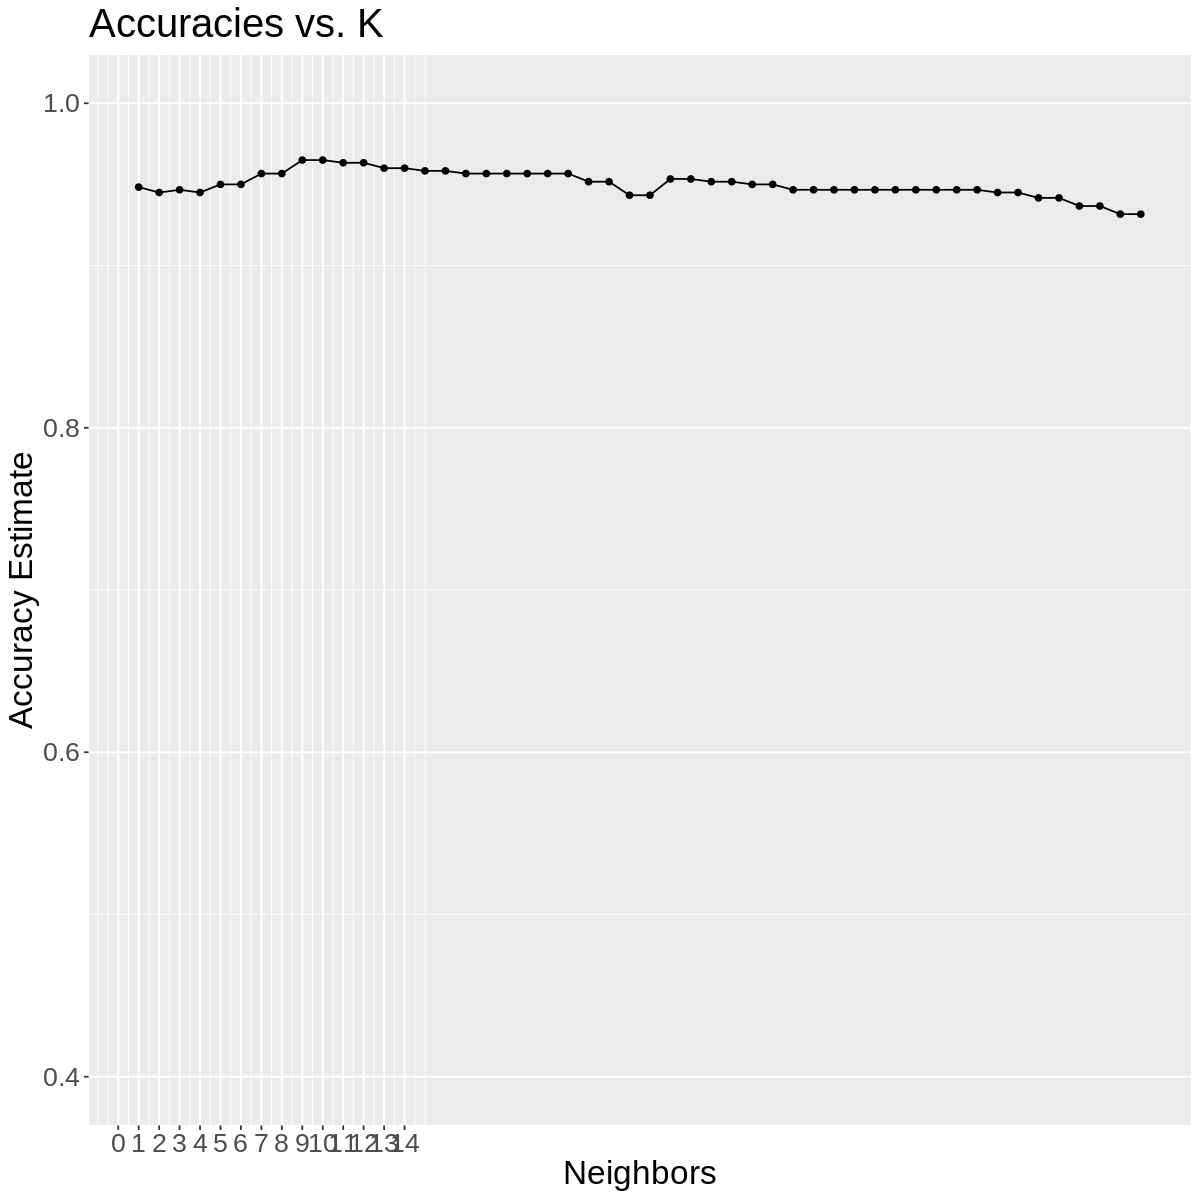

In [22]:
#cross-validate and tune the model using a 10-fold cross-validation
pokemon_vfold <- vfold_cv(pokemon_train, v = 10, strata = Legendary)

kvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

pokemon_k_test <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(pokemon_spec) |>
    tune_grid(resamples = pokemon_vfold, grid = kvals) |>
    collect_metrics()

accuracies <- pokemon_k_test |>
    filter(.metric == "accuracy")
head(accuracies)

options(repr.plot.width = 10, repr.plot.height =10)
k_val_plot <-  ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle ("Accuracies vs. K")+
       theme(text = element_text(size =20))+ 
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
k_val_plot

Table 4. Accuracies of training set data.

Figure 2. Accuracy Estimate vs. K-Nearest Neighbours. 

Here we are using K=9 because we can see an increase in accuracy between 8 and 9, and later stabilizes as you increase the number of clusters. Therefore 9 clusters offers the least number of neighbors for the highest accuracy. 

In [14]:
#create a new model with k = 9
pokemon_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
                set_engine("kknn") |>
                set_mode("classification")

pokemon_fit <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(pokemon_best_spec) |>
    fit(data = pokemon_train)
pokemon_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1418182
Best kernel: rectangular
Best k: 9

Recipe, workflow and fit will be used again to train the classifier using the training dataset.

In [19]:
pokemon_predictions <- predict(pokemon_fit, pokemon_test) |>
                     bind_cols(pokemon_test) 
head(pokemon_predictions)    

pokemon_metrics <- pokemon_predictions |>
                 metrics(truth = Legendary, estimate = .pred_class) |>
                 filter(.metric == "accuracy")
pokemon_metrics

pokemon_conf_mat <- pokemon_predictions |>
                  conf_mat(truth = Legendary, estimate = .pred_class)
pokemon_conf_mat

.pred_class,Name,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Legendary,total_stats
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
FALSE,Venusaur,80,82,83,100,100,80,FALSE,525
FALSE,Charmander,39,52,43,60,50,65,FALSE,309
FALSE,CharizardMega Charizard X,78,130,111,130,85,100,FALSE,634
FALSE,Weedle,40,35,30,20,20,50,FALSE,195
FALSE,BeedrillMega Beedrill,65,150,40,15,80,145,FALSE,495
FALSE,Pidgeotto,63,60,55,50,50,71,FALSE,349


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.965


          Truth
Prediction FALSE TRUE
     FALSE   183    5
     TRUE      2   10

Table 5. Prediction of pokemon class (legendary vs. non legendary). 

Table 6. Matrix for predictions using testing data. 

Accuracy is tested using the testing dataset by comparing it to the model made by the training dataset. Here 193 (183+10) pokemon were predicted correctly and 7 (2+5) predicted incorrectly. This gives us an accuracy of 96.5% for our model. 

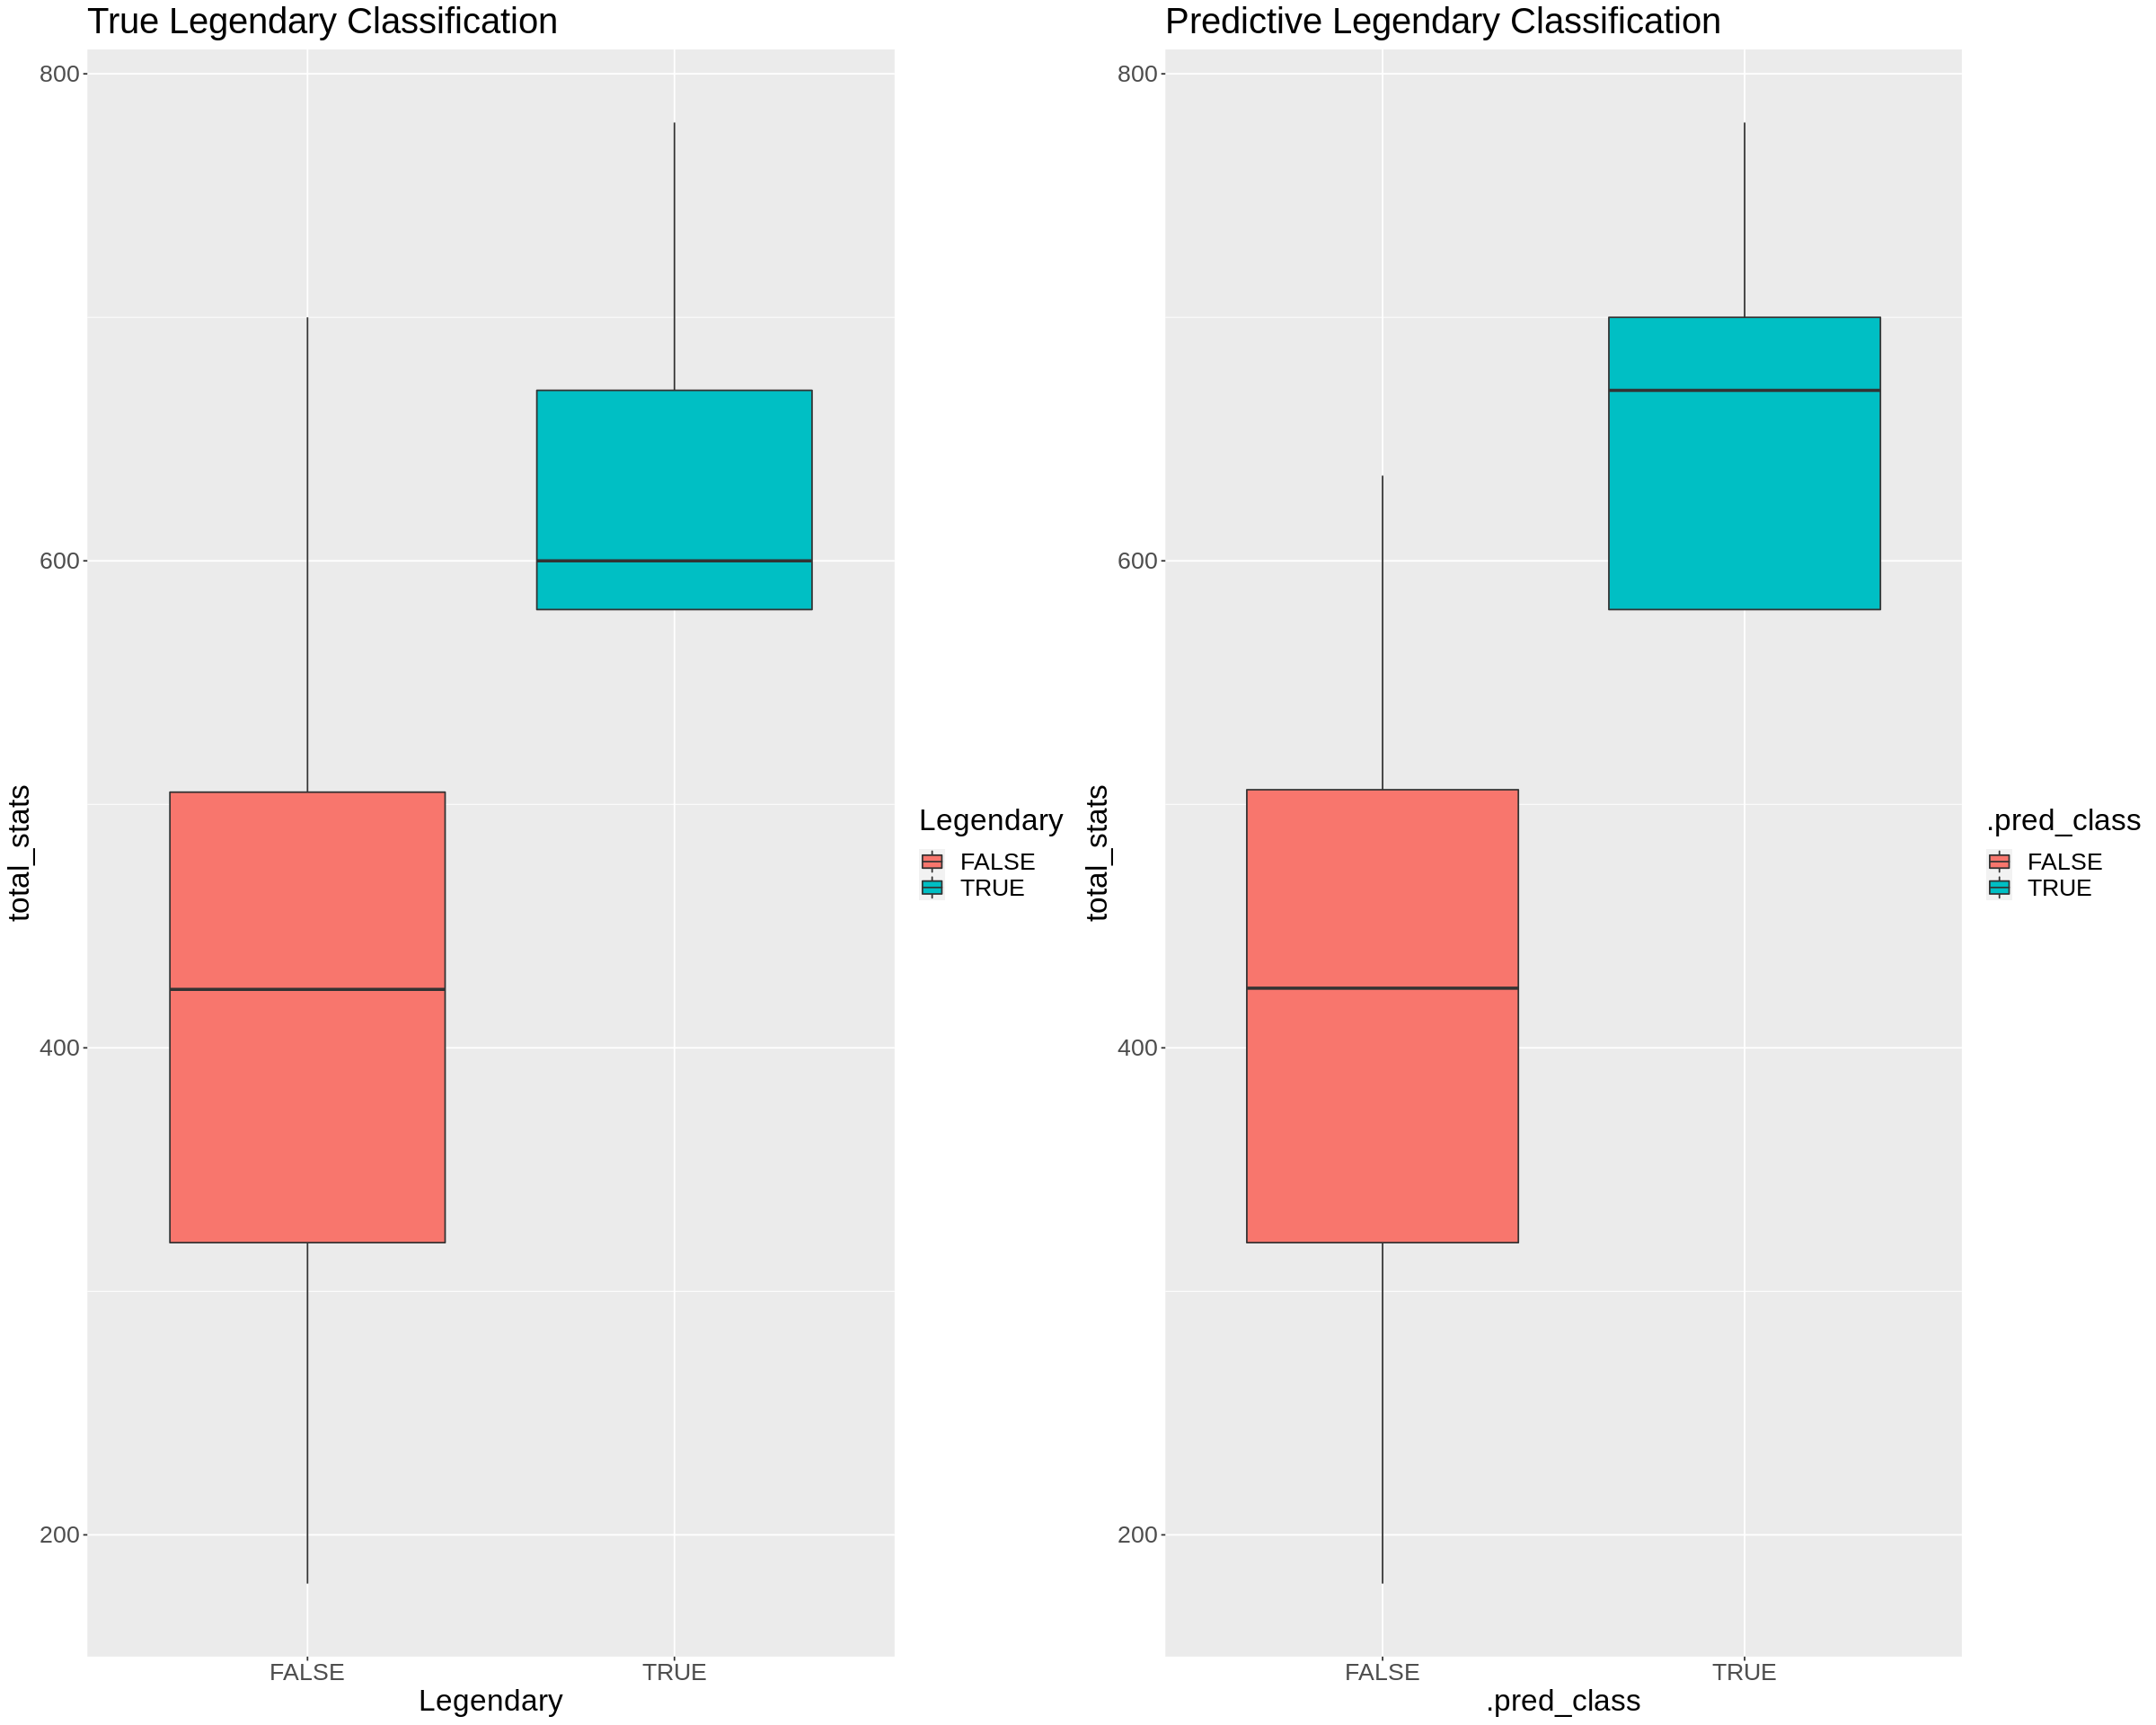

In [32]:
options(repr.plot.width = 20, repr.plot.height =16)
pokemon_true_box_plot <- pokemon_predictions |>
    ggplot(aes(x = Legendary, y = total_stats, fill = Legendary)) +
    geom_boxplot() +
    ggtitle("True Legendary Classification") +
    theme(text = element_text(size =20))

pokemon_pred_box_plot <- pokemon_predictions |>
    ggplot(aes(x = .pred_class, y = total_stats, fill = .pred_class)) +
    geom_boxplot() +
    ggtitle("Predictive Legendary Classification") +
    theme(text = element_text(size =20))

plot_grid(pokemon_true_box_plot, pokemon_pred_box_plot, ncol=2)

Figure 3A. True Pokemon Stats Plot (first plot) 

Figure 3B. Predicted Pokemon Stats Plot (second plot) 

By using both of these plots, the classification of legendary with their statistics can be compared. We can see that the model (Fig 3B) generally performed well, with higher 'total stats' values being classified as legendary (similiar shape and distribution as Fig 3A) with minimal error. For example, the mean is represented by the horizontal line in the box, and we can see the predictive class often put higher values as legendary, therefore having a higher avg stat. This observation can also be seen in the whiskers of the plot with the predictive class having shorter/lower maximum value due to the classifyer clustering them as legendary. 

In [17]:
new_pokemon <- tibble(total_stats = 523, Name = "Dsci Beast") 

predict(pokemon_fit, new_pokemon)

.pred_class
<fct>
FALSE


Here we tested our model by inputting a hypothetical pokemon with total_stats of 523 and produced FALSE. This is expected as on our 'pokemon prediction box plot' (Figure 3) this Pokemon would lie within the range of the non-legendary Pokemon, classifying it as non-legendary. This indicates our analysis agreed with what we expected to see, and our predictive model was able to successively predict our Pokemon. 

Discussion: 

This analysis was expected to demonstrate that our Pokemon is classified as legendary if its attack, defense, special defense, hp, and speed variables lie within the range of other legendary Pokemon, and a non-legendary Pokemon if they lie below it. After analyzing our data, we determined that our predictive model works as we expected. First, we made a 75% training model using all the chosen variables of the Pokemon and then used a 25% testing data set to determine our models accuracy. Using this, we noticed that the a k-nearest neighbor value of 9 provided the best accuracy of 97%. This accuracy demonstrated the data was sufficient to use in predicting our Pokemon. We converted “Legendary” into a factor in order to use statistical functions of the column. We visualized our findings in a box plot, noticing that significant differences in variable values between legendary (blue) and non-legendary (red) Pokemon exist, with values significantly larger for legendary Pokemon compared to non-legendary Pokemon. By creating this plot, in theory, we could plot any Pokemon to determine whether it is legendary or not. 

Though our predictive model was able to predict the legendary status of our Pokemon in theory, these results may demonstrate no impact as legendary Pokemon can only be deemed legendary by the game developers themselves and there is no perfect way to determine them otherwise. However, our findings can be used by these game developers in using the general statistics found to create legendary and non-legendary Pokemon, as well as used by game players to analyze the strength and value of their own Pokemon based on its own statistics. In the development of new Pokemon, this analysis leads to the future question of what the threshold of the different attack, special attack, defense, special defense, HP, and speed variables game developers can set for a legendary Pokemon in order to ensure fairness of play between others in the future.



Citations:

    Barradas, A. (2016, August 29). Pokemon with stats. Kaggle. https://www.kaggle.com/datasets/abcsds/pokemon 

    Pokemon. (2015). In Encyclopædia Britannica. Retrieved from http://www.britannica.com/EBchecked/topic/1474435/Pokemon

    Padilla, R. (2003, March 17). Pok¿Mon Ruby/Sapphire. GameSpy. https://web.archive.org/web/20131002205143/http://uk.gba.gamespy.com/gameboy-advance/pokemon-ruby-version/498107p1.html

    Serebii.net. (2023). Serebii.net games - statistics. Serebii.net Header. https://www.serebii.net/games/stats.shtml 
